In [1]:
import os
import numpy as np
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sys
from contextlib import contextmanager
import shutil
from concurrent.futures import ThreadPoolExecutor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fungsi suppress_stdout() menggunakan context manager untuk menekan output ke konsol dengan mengalihkannya ke file dummy selama eksekusi blok kode tertentu, dan mengembalikan output ke keadaan normal setelahnya.

In [3]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
start_time = time.time()

In [5]:
base_dir = '/content/drive/My Drive/TA/skin_main1'

Menggabungkan base_dir dengan nama subdirektori untuk empat jenis penyakit kulit, menggunakan os.path.join() untuk memastikan format path yang benar sesuai sistem operasi, sehingga menghasilkan path lengkap untuk setiap jenis penyakit.

In [6]:
basal_cell_carcinoma_dir = os.path.join(base_dir, 'basal_cell_carcinoma')
melanoma_dir = os.path.join(base_dir, 'melanoma')
squamous_cell_carcinoma_dir = os.path.join(base_dir, 'squamous_cell_carcinoma')
healthy_skin_dir = os.path.join(base_dir, 'healthy_skin')

Membagi gambar dari empat jenis penyakit kulit menjadi set pelatihan dan validasi dengan proporsi validasi 20% menggunakan fungsi train_test_split. Direktori untuk set pelatihan dan validasi kemudian ditetapkan dengan menggabungkan base_dir dengan subdirektori 'train' dan 'val' untuk penyimpanan yang terorganisir.

In [7]:
train_basal_cell_carcinoma_dir, val_basal_cell_carcinoma_dir = train_test_split(os.listdir(basal_cell_carcinoma_dir), test_size=0.2)
train_melanoma_dir, val_melanoma_dir = train_test_split(os.listdir(melanoma_dir), test_size=0.2)
train_squamous_cell_carcinoma_dir, val_squamous_cell_carcinoma_dir = train_test_split(os.listdir(squamous_cell_carcinoma_dir), test_size=0.2)
train_healthy_skin_dir, val_healthy_skin_dir = train_test_split(os.listdir(healthy_skin_dir), test_size=0.2)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Memeriksa dan membuat direktori train_dir dan validation_dir jika belum ada, lalu menetapkan path untuk subdirektori pelatihan dan validasi dari empat jenis penyakit kulit. Ini memfasilitasi penyimpanan dan akses data yang terorganisir untuk pelatihan model.

In [8]:
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

train_basal_cell_carcinoma = os.path.join(train_dir, 'basal_cell_carcinoma')
train_melanoma = os.path.join(train_dir, 'melanoma')
train_squamous_cell_carcinoma = os.path.join(train_dir, 'squamous_cell_carcinoma')
train_healthy_skin = os.path.join(train_dir, 'healthy_skin')

val_basal_cell_carcinoma = os.path.join(validation_dir, 'basal_cell_carcinoma')
val_melanoma = os.path.join(validation_dir, 'melanoma')
val_squamous_cell_carcinoma = os.path.join(validation_dir, 'squamous_cell_carcinoma')
val_healthy_skin = os.path.join(validation_dir, 'healthy_skin')

Melooping melalui daftar direktori pelatihan dan validasi, membuat direktori yang belum ada dengan os.mkdir(). Ini memastikan bahwa semua direktori yang diperlukan tersedia untuk menyimpan data pelatihan dan validasi.

In [9]:
for directory in (train_basal_cell_carcinoma, train_melanoma, train_squamous_cell_carcinoma, train_healthy_skin, val_basal_cell_carcinoma, val_melanoma, val_squamous_cell_carcinoma, val_healthy_skin):
    if not os.path.exists(directory):
        os.mkdir(directory)

Fungsi copy_file menggunakan modul shutil untuk menyalin file dari lokasi source ke lokasi dest

In [10]:
def copy_file(source, dest):
    shutil.copy(source, dest)

Menggunakan ThreadPoolExecutor dengan empat penyakit kulit untuk menyalin file secara paralel dari direktori sumber ke direktori pelatihan dan validasi. Fungsi copy_file dipanggil untuk setiap file, memaksimalkan efisiensi dengan menjalankan tugas penyalinan secara simultan, mengurangi waktu yang dibutuhkan untuk proses tersebut.

In [11]:
with ThreadPoolExecutor(max_workers=4) as executor:
    for i in train_basal_cell_carcinoma_dir:
        executor.submit(copy_file, os.path.join(basal_cell_carcinoma_dir, i), os.path.join(train_basal_cell_carcinoma, i))
    for i in train_melanoma_dir:
        executor.submit(copy_file, os.path.join(melanoma_dir, i), os.path.join(train_melanoma, i))
    for i in train_squamous_cell_carcinoma_dir:
        executor.submit(copy_file, os.path.join(squamous_cell_carcinoma_dir, i), os.path.join(train_squamous_cell_carcinoma, i))
    for i in train_healthy_skin_dir:
        executor.submit(copy_file, os.path.join(healthy_skin_dir, i), os.path.join(train_healthy_skin, i))


    for i in val_basal_cell_carcinoma_dir:
        executor.submit(copy_file, os.path.join(basal_cell_carcinoma_dir, i), os.path.join(val_basal_cell_carcinoma, i))
    for i in val_melanoma_dir:
        executor.submit(copy_file, os.path.join(melanoma_dir, i), os.path.join(val_melanoma, i))
    for i in val_squamous_cell_carcinoma_dir:
        executor.submit(copy_file, os.path.join(squamous_cell_carcinoma_dir, i), os.path.join(val_squamous_cell_carcinoma, i))
    for i in val_healthy_skin_dir:
        executor.submit(copy_file, os.path.join(healthy_skin_dir, i), os.path.join(val_healthy_skin, i))

Fungsi pertama, remove_hair, menghilangkan rambut dari gambar penyakit kulit. Ini dilakukan dengan mengubah gambar menjadi skala abu-abu, menerapkan operasi morfologi blackhat untuk menyoroti area gelap seperti rambut, mengintensifkan daerah gelap ini dalam gambar, dan akhirnya menggunakan teknik inpainting untuk menghilangkan rambut dengan mengganti area yang ditandai dengan tekstur di sekitarnya.

Fungsi kedua, enhance_contrast, meningkatkan kontras gambar penyakit kulit menggunakan teknik CLAHE (Contrast Limited Adaptive Histogram Equalization). Fungsi ini menyesuaikan kontras lokal dari gambar dan bekerja dengan gambar berwarna atau skala abu-abu. Untuk gambar berwarna, kontras ditingkatkan pada saluran luminansinya (saluran 'L' dari ruang warna LAB) sebelum mengkonversi kembali ke RGB. Fungsi ini memperbaiki visibilitas detail dalam gambar dengan menyamakan distribusi cahaya.

In [12]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet
from skimage.color import rgb2gray, gray2rgb
from skimage import exposure

# Contrast enhancement using CLAHE
def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Check if the image is colored
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        lab_planes = cv2.split(lab)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        enhanced_img = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
    else:  # If the image is grayscale
        enhanced_img = clahe.apply(image)

    return enhanced_img

*   apply_edge_detection: Menerapkan deteksi tepi menggunakan filter Sobel untuk menyoroti kontur dalam gambar.
*   
apply_gaussian_filter: Mengurangi noise dengan filter Gaussian, di mana sigma mengatur tingkat kehalusan yang diaplikasikan.

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import img_as_ubyte
from scipy.ndimage import gaussian_filter

# Apply edge detection
def apply_edge_detection(image):
    return sobel(image)

# Apply Gaussian filter for noise reduction
def apply_gaussian_filter(image, sigma=1.5):
    return gaussian_filter(image, sigma=sigma)


Fungsi adaptive_histogram_equalization meningkatkan kontras gambar dengan menggunakan CLAHE jika label gambar termasuk 'basal_cell_carcinoma', 'actinic_keratosis', 'nevus', atau 'vascular_lesion'. CLAHE diterapkan pada saluran luminansi gambar berwarna di ruang LAB atau langsung pada gambar skala abu-abu.

In [14]:
# Apply adaptive equalization selectively based on label
def adaptive_histogram_equalization(image, label):
    if label in ['basal_cell_carcinoma','melanoma','squamous_cell_carcinoma', 'healthy_skin']:
        # Use CLAHE for lesions that might have subtle variations
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        if len(image.shape) == 3 and image.shape[2] == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            lab_planes = cv2.split(lab)
            lab_planes[0] = clahe.apply(lab_planes[0])
            lab = cv2.merge(lab_planes)
            return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
        else:
            return clahe.apply(image)
    else:
        # For other lesions, use standard histogram equalization
        return exposure.equalize_hist(image)

Mengatur ImageDataGenerator dari TensorFlow Keras untuk augmentasi dan preprocessing gambar dalam pelatihan dan validasi. Untuk pelatihan, konfigurasi mencakup reskala, rotasi, perpindahan, pemotongan, zoom, flip, perubahan kanal, penyesuaian kecerahan, dan mode pengisian piksel. Hanya reskala yang diterapkan pada data validasi. Generator-generatormu kemudian memuat gambar dari direktori yang ditentukan, menyesuaikan ukuran target, ukuran batch, dan mode kelas, dengan suppress_stdout() digunakan untuk menekan output selama operasi ini agar keluaran tetap bersih.

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

with suppress_stdout():
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

menghitung steps_per_epoch dan validation_steps dengan membagi total sampel di generator pelatihan dan validasi dengan ukuran batch mereka. Hal ini menentukan jumlah iterasi yang diperlukan dalam satu epoch untuk masing-masing.

In [16]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

menginisialisasi objek EarlyStopping untuk menghentikan pelatihan model jika tidak ada peningkatan dalam val_loss selama 5 epoch berturut-turut. Itu akan memberikan pesan saat pelatihan dihentikan, dan mode ditetapkan sebagai minimum untuk memantau penurunan val_loss.

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0.01,
    mode='min'
)

 menciptakan objek ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_accuracy ke dalam file 'best_model.h5'.

In [18]:
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=False, #coba di false awalnya true untuk menyimpan akurasi dengan val_accuracynya lebih tinggi dari sebelumnya
    verbose=1
)

In [19]:
max_training_time = 30 * 60

 menginisialisasi model DenseNet121 yang telah dipretrain pada dataset ImageNet. Model ini tidak termasuk layer penuh (fully connected layer) di bagian atasnya, dan membutuhkan input dengan ukuran (224, 224, 3).

In [20]:
# DenseNet121 model, pretrained on ImageNet
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# MobilenetV2 model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Menginisialisasi arsitektur VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

menginisialisasi model neural network secara sequential (CNN) dengan menggunakan base model DenseNet121 yang telah di-pretrain.

In [21]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 28817

secara iteratif menonaktifkan pelatihan (freeze) pada setiap layer dalam base model DenseNet121 dengan mengatur layer.trainable = False.

In [23]:
for layer in base_model.layers:
    layer.trainable = False

mengompilasi model dengan pengoptimal Adam, fungsi kerugian categorical crossentropy, dan metrik akurasi yang akan dievaluasi selama pelatihan.

In [24]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

menciptakan objek ReduceLROnPlateau untuk mengurangi laju pembelajaran saat val_loss stagnan. Faktor pengurangan adalah 0.1, dengan patience=1 untuk mengatur berapa lama stagnasi sebelum penurunan, dan minimum laju pembelajaran dijaga pada 0.001.

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.001)

menghitung jumlah total gambar dalam setiap direktori pelatihan (train) dan validasi (val) untuk kelas-kelas berbeda (basal cell carcinoma, actinic keratosis, nevus, dan vascular lesion) dan menyimpannya dalam variabel total_train_images dan total_val_images masing-masing.

In [26]:
total_train_images = len(train_basal_cell_carcinoma_dir) + len(train_melanoma_dir) + len(train_squamous_cell_carcinoma_dir) + len(train_healthy_skin_dir)
total_val_images = len(val_basal_cell_carcinoma_dir) + len(val_melanoma_dir) + len(val_squamous_cell_carcinoma_dir) + len(val_healthy_skin_dir)

melatih model dengan metode fit, menggunakan generator untuk data pelatihan dan validasi. Jumlah langkah per epoch diatur berdasarkan ukuran batch. Callbacks early_stopping dan model_checkpoint digunakan untuk menghentikan pelatihan jika tidak ada peningkatan dalam val_loss dan menyimpan model terbaik.

In [27]:
batch_size = 32  # Or whatever size fits your dataset and model architecture

history = model.fit(
    train_generator,
    steps_per_epoch=total_train_images // batch_size,
    epochs=10,  # diganti 10, 20
    validation_data=validation_generator,
    validation_steps=total_val_images // batch_size,
    callbacks=[model_checkpoint]
)

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 0.9849 - accuracy: 0.6187
Epoch 1: saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 96s 3s/step - loss: 0.9849 - accuracy: 0.6187 - val_loss: 0.7227 - val_accuracy: 0.7455
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7312
Epoch 2: saving model to best_model.h5
30/30 [==============================] - 84s 3s/step - loss: 0.6739 - accuracy: 0.7312 - val_loss: 0.8148 - val_accuracy: 0.7500
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7896
Epoch 3: saving model to best_model.h5
30/30 [==============================] - 84s 3s/step - loss: 0.5219 - accuracy: 0.7896 - val_loss: 0.8506 - val_accuracy: 0.7321
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.8062
Epoch 4: saving model to best_model.h5
30/30 [==============================] - 84s 3s/step - loss: 0.4568 - accuracy: 0.8062 - val_loss: 0.7399 - val_accuracy: 0.7634
Epoch 5/20
30/30 [==============================] - ETA: 0s - loss: 0.4696 - accuracy

In [28]:
end_time = time.time()
training_time = end_time - start_time

In [29]:
if training_time > max_training_time:
    print("Pelatihan melebihi waktu yang ditentukan, memuat model terbaik...")
    model.load_weights('best_model.h5')
else:
    print(f"Total training time: {training_time:.2f} seconds")

Pelatihan melebihi waktu yang ditentukan, memuat model terbaik...


In [30]:
print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")

Total training images: 960
Total validation images: 240


memuat bobot terbaik yang telah disimpan sebelumnya ke dalam model menggunakan metode load_weights.

In [31]:
model.load_weights('best_model.h5')

mengevaluasi model menggunakan data dari generator validasi dengan jumlah langkah yang telah ditentukan. Hasil evaluasi disimpan dalam variabel evaluation.

In [32]:
evaluation = model.evaluate(validation_generator, steps=validation_steps)
print(f"Akurasi model pada validation set: {evaluation[1] * 100:.2f}%")

7/7 [==============================] - 7s 1s/step - loss: 0.8576 - accuracy: 0.7589
Akurasi model pada validation set: 75.89%


melakukan evaluasi model menggunakan data validasi dari generator dengan parameter shuffle diatur ke False untuk menjaga konsistensi urutan data antar percobaan. Kemudian, model dievaluasi seperti sebelumnya dan prediksi kelas dilakukan. Berdasarkan prediksi dan label sebenarnya, dilakukan perhitungan matriks kebingungan (confusion matrix) dan beberapa metrik evaluasi seperti presisi, recall, F1 score, dan akurasi.

Found 240 images belonging to 4 classes.
7/7 [==============================] - 9s 976ms/step
Precision: 0.82
Recall: 0.76
F1 Score: 0.76
Accuracy: 0.76


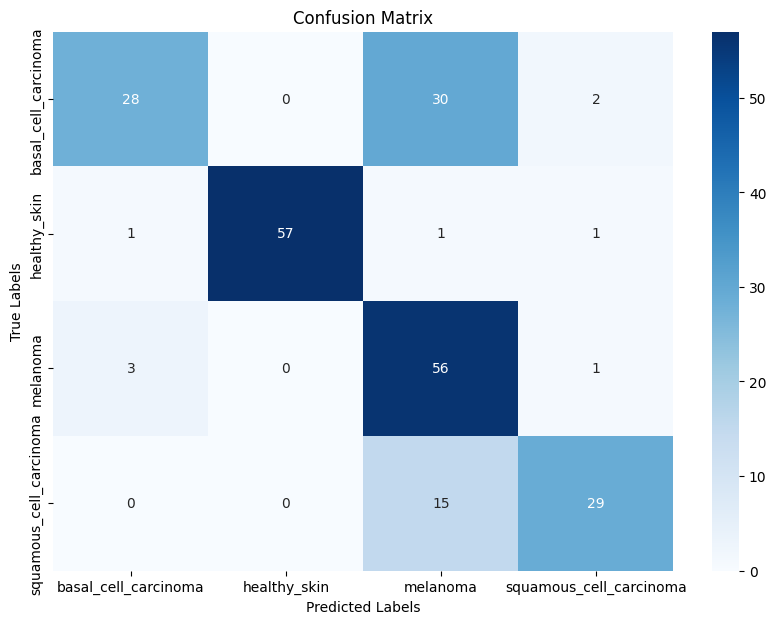

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

# Create the validation generator with shuffle set to False
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep order consistent between runs
)

validation_steps = np.floor(validation_generator.samples / validation_generator.batch_size)  # Untuk `model.evaluate`

# Proceed with the model evaluation as before
validation_generator.reset()  # Reset the generator before making predictions
pred = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(pred, axis=1)

# Get the class labels from the validation generator
class_labels = list(validation_generator.class_indices.keys())

# Ensure true_classes length matches predicted_classes
true_classes = validation_generator.classes[:len(predicted_classes)]  # Adjust this line if needed

# Compute the confusion matrix and metrics
cm = confusion_matrix(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

memvisualisasikan histori pelatihan model dengan plot akurasi dan loss pada data pelatihan dan validasi selama setiap epoch. Panjang setiap seri data dievaluasi untuk memastikan kesesuaian.

Length of accuracy: 20
Length of validation accuracy: 20
Length of loss: 20
Length of validation loss: 20


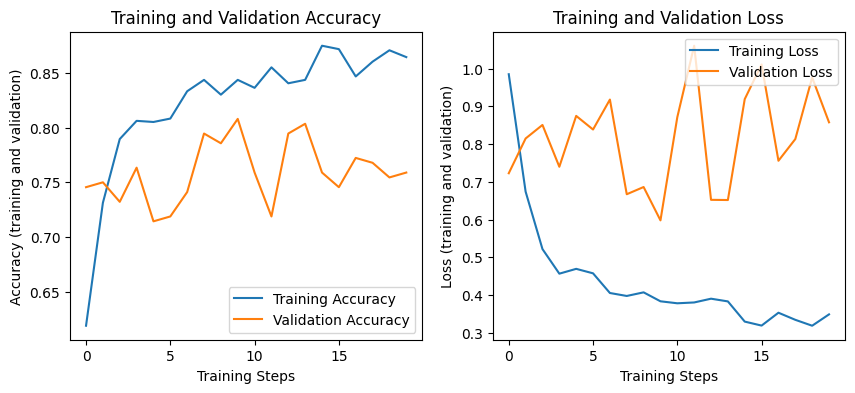

In [34]:
%matplotlib inline

# Assuming 'history' is a variable containing the training history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Print lengths to check alignment
print("Length of accuracy:", len(acc))
print("Length of validation accuracy:", len(val_acc))
print("Length of loss:", len(loss))
print("Length of validation loss:", len(val_loss))

# Set epochs to the length of one of these arrays if they are the same
epochs = len(acc)  # Change this to match your data

epochs_range = range(epochs)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

plt.show()

In [35]:
uploaded = files.upload()

Saving ISIC_0026192.jpg to ISIC_0026192.jpg


In [36]:
class_labels = {v: k for k, v in train_generator.class_indices.items()}

melakukan prediksi kelas untuk setiap gambar yang diunggah dan menampilkannya bersama dengan label prediksi. Setiap gambar dimuat, diubah menjadi array, diperluas dimensinya, dan dinormalisasi. Kemudian, prediksi kelas dilakukan menggunakan model, dan hasilnya digunakan untuk menampilkan label prediksi di atas gambar.

1/1 [==============================] - 1s 1s/step


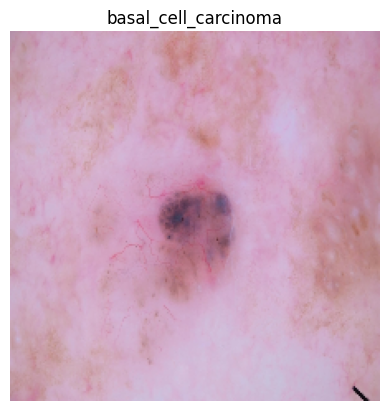

In [37]:
for fn in uploaded.keys():
    path = '/content/' + fn
    img = image.load_img(path, target_size=(224, 224))  # Update the target_size to (224, 224)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Normalize the image pixels to 0-1 (if the model was trained with normalized images)
    x = x / 255.0

    images = np.vstack([x])
    classes = model.predict(images)

    predicted_class = class_labels[np.argmax(classes)]
    plt.title(f"{predicted_class}")
    plt.show()

In [38]:
import time

t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

In [39]:
import tensorflow_hub as hub

export_path
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

mengonversi model ke format TFLite. Objek TensorFlow Lite Converter dibuat dengan concrete function dari model, dan model dikonversi ke format TFLite. Hasilnya disimpan dalam file "tflite_models/best_model.tflite".

In [40]:
# Convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/best_model.tflite"

# Get the concrete function from the keras model
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function
concrete_func = run_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


11498180